In [149]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import logsumexp
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from tqdm import tqdm
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10) # (w, h)



def extractdata(classification):
    """
        Extracts the  data given the path 
    """ 
    data  = pd.read_csv(classification,sep = ' ', header=None, engine='python')
    X = data.values[:,0:2]
    return X

U = extractdata('classification_data_HWK2/EMGaussian.data')
Utest = extractdata('classification_data_HWK2/EMGaussian.test')


# Definition of the gaussian density function with non isotropic covariance matrix
def gauss(X, mu, sigma):
    """
    Computes the images of the rows of X by the gaussian of mean mu and covariance S
    """
    if(len(X.shape) == 1):
        X = X[np.newaxis, ...]
    p = X.shape[1]
    Sinv = np.linalg.pinv(sigma)
    det = np.linalg.det(sigma)
    const = (1.0 / np.sqrt((2 * np.pi * det) ** p))
    return const * np.exp(-0.5 * np.einsum("ij,ij->i", (X - mu), Sinv.dot((X - mu).T).T))

# gaussian density in log scale
def gauss_log(X, mu, sigma):
    """
    Gaussian density in log scale
    """
    if(len(X.shape) == 1):
        X = X[np.newaxis, ...]
    p = X.shape[1]
    Sinv = np.linalg.pinv(sigma)
    det = np.linalg.det(sigma)
    return - p * np.log(np.sqrt(2 * np.pi * det)) - 0.5 * np.einsum("ij,ij->i", (X - mu), Sinv.dot((X - mu).T).T)


In [145]:
class HMM(object):
    """
    Class for Hidden Markov model
    """
    def __init__(self):
        self.pi1 = None # Initial class probabilities
        self.A = None # Transition matrix 
        self.means = None # Means of the gaussians
        self.sigmas = None # Covariances of the gaussians

    def alpha_log(self, U, pi1, A, means, sigmas):
        """
        Computes the alpha messages recursively
        """
        T = np.shape(U)[0] # Number of observations
        K = np.shape(pi1)[0] # Number of classes
        A_log = np.log(A) # Transition matrix in logscale

        # Initialization
        logalphas = np.zeros((T, K))
        logalphas[0] = np.log(pi1) + np.hstack([gauss_log(U[0], mu, sigma) for (mu, sigma) in zip(means, sigmas)])
        
        log_emissions = np.vstack([gauss_log(U, mu, sigma) for (mu, sigma) in zip(means, sigmas)]).T
        # Alpha recursions
        for t in range(1, T):
            for i in range(K):
                logalphas[t][i] = log_emissions[t, i] + logsumexp(A_log[i] + logalphas[t-1])

        return logalphas
    
    
    def beta_log(self, U, pi1, A, means, sigmas):
        """
        Computes the beta messages recursively
        """
        T = np.shape(U)[0] # Number of observations
        K = np.shape(pi1)[0] # Number of classes
        A_log = np.log(A) # Transition matrix in logscale
        # Initialization
        logbetas = np.zeros((T, K))
        logbetas[T-1] = np.zeros(np.shape(pi1))

        # Beta recursions
        for t in range(1, T):
            for j in range(K):
                log_ems = np.array([gauss_log(U[T-t], mu, sigma) for (mu, sigma) in zip(means, sigmas)])
                logbetas[T-t-1][j] = logsumexp(A_log[:, j] + log_ems + logbetas[T-t])
                
        return logbetas
    
    
    def E_step(self, U, log_alphas, log_betas):
        """  
        Performs the E step of the EM for HMM
        """
        T,d = np.shape(U)
        K = np.shape(self.A)[1]
        A_log = np.log(self.A)
        
        # Log-Likelihood of the observations
        likelihoods = logsumexp(log_alphas + log_betas, axis=1)

        # Compute marginal posterior probabilities in log scale

        marg_post = log_alphas + log_betas - likelihoods[..., np.newaxis]
        
        # Compute joint posterior probabilities
        gauss_logs = np.stack([gauss_log(U[1:], mu, sigma) for (mu, sigma) in zip(self.means, self.sigmas)]) 

        joint_messages = log_alphas[:(T-1), :, np.newaxis].swapaxes(1,2) + log_betas[1:, :, np.newaxis] 

        joint_post = joint_messages + A_log  + gauss_logs[...,np.newaxis].swapaxes(0,1) - likelihoods[1:, np.newaxis, np.newaxis]
        
        return np.exp(marg_post), np.exp(joint_post)
    
    def M_step(self, U, tau, nu):
        """
        Performs the M-step of the EM on the Hidden markov model
        """
        T, K = np.shape(tau)
        pi1 = tau[1]
        
        self.A = np.sum(nu,axis = 0)/ np.sum(nu, axis = (0,1))

        self.means = np.einsum('k,kp->kp', 1.0 / np.sum(tau, axis=0), np.dot(tau.T, U))

        self.sigmas = np.einsum('k,klm->klm', 
                                   1.0 / np.sum(tau, axis=0),
                                   np.stack([np.dot(np.einsum('i,ik->ik', tau[:, j], U - mu).T, U - mu) for j, mu in enumerate(self.means)]))
        return 
        
    def fit(self, U, K=5,  Niter=50, Utest=None,
            pi1_0=None, A0=None, means0=None, sigmas0=None):
        """
        Computes the parameters of the Hidden Markov model with gaussian emission probabilities,
        using the EM algorithm. 
        """
        n, p = U.shape
        
        if(pi1_0 == None):
            pi1_0 = (1.0 / n_classes) * np.ones(K)
        if(means0 == None):
            means0 = U[np.random.randint(n, size=K)]
        if (sigmas0 == None):
            sigmas0 = np.stack([np.identity(p) * (i + 1) for i in range(K)], axis = 0)
        if(A0 == None):
            A0 = np.identity(K) + np.ones((K, K))
            A0 /= np.sum(A0, axis=1)
        self.pi1 = pi1_0
        self.A = A0
        self.means = means0
        self.sigmas = sigmas0
        
        log_l = np.zeros(Niter) #  log likelihoods on training set
        if (Utest is not None):
            log_l_test = np.zeros(Niter) # log likelihoods on test set
        
        for i in range(Niter):
            # Alpha, Beta message passing
            la = self.alpha_log(U, self.pi1, self.A, self.means, self.sigmas) # Alpha messages in log scale
            lb = self.beta_log(U, self.pi1, self.A, self.means, self.sigmas) # Beta messages in log scale
            log_l[i] = (logsumexp(la + lb, axis=1))[0]
            if(Utest is not None):
                la_test = self.alpha_log(Utest, self.pi1, self.A, self.means, self.sigmas)
                lb_test = self.beta_log(Utest, self.pi1, self.A, self.means, self.sigmas)
                log_l_test[i] = (logsumexp(la_test + lb_test, axis=1))[0]
            
            # E step
            tau, nu = self.E_step(U, la, lb)
            
            # M step
            self.M_step(U, tau, nu)
        
        
        if(Utest is None):
            return self.pi1, self.A, self.means, self.sigmas, log_l
        
        else:
            return self.pi1, self.A, self.means, self.sigmas, log_l, log_l_test


    def predict_proba(self, U, logscale = True):
        """
        Computes the probabilities for each class of the t-th hidden variable qt in log scale
        """
        T, d = np.shape(U)
        K = np.shape(self.pi1)[0]

        log_alphas = self.alpha_log(U, self.pi1, self.A, self.means, self.sigmas)
        log_betas = self.beta_log(U, self.pi1, self.A, self.means, self.sigmas)
        log_proba = log_alphas + log_betas - logsumexp(log_alphas + log_betas, axis=1)
        
        if(logscale):
            return log_proba
        else:
            return np.exp(log_proba)
        
    def predict(self, U):
        """
        Predicts the class (hidden variable) of each observation in U
        """
        log_prob = self.predict_proba(U)
        return np.argmax(log_prob, axis=1)
    
    def viterbi(self, U):
        """
        Computes the most likely sequence recursively using the Viterbi algorithm
        """
        #initialization phase
        n = np.shape(self.A)[0]
        t = np.shape(U)[0]
        
        al = np.log(self.pi1[..., np.newaxis])
        
        
        #write coefficient in log scale
        factors = [gauss_log(U[0], mu, sigma) for (mu, sigma) in zip(self.means, self.sigmas)]
        al += np.reshape(factors, [n, 1])
        Alog = np.log(A)
        
        previous = np.reshape(np.zeros(4), [4, 1])

        #dynamic extension of alpha


        for k in range(1, t):
            
            old = np.reshape(al[:, -1], [1, n])
            factors = [gauss_log(U[k], mu, sigma) for (mu, sigma) in zip(self.means, self.sigmas)]
            factors = np.reshape(factors, [n, 1])

            tmp = Alog + old + factors 
            new = np.reshape(np.max(tmp, 1), [n, 1])
            prev = np.where(tmp == new)[1]
            prev = np.reshape(prev, [n, 1])
            al = np.c_[al, new]
            previous = np.c_[previous, prev]

        previous = previous[:,1:]
        # construct the sequence with the highest probability
        lab = np.zeros(t)
        lab[t-1] = np.where(al[:, -1]==max(al[:, -1]))[0][0]
        for k in range(2,t+1):
            lab[-k]= previous[int(lab[1-k]), 1-k]

        return lab 
    
    
# Plot functions
def make_grid(data=None, xmin=-5, xmax=5, ymin=-5, ymax=5, n_points = 400):
    """
    Computes a plotting grid given the data.
    xmin, xmax, ymin, ymax is used by default if no data is given as input
    """
    if data is not None:
        xmin, ymin = np.min(data, axis = 0)
        xmax, ymax = np.max(data, axis = 0)

    x, y = np.meshgrid(np.linspace(xmin, xmax, n_points), np.linspace(ymin, ymax, n_points))
    grid = np.c_[x.ravel(), y.ravel()] # grid has n_points ^2 row and 2 columns
    return x, y, grid



No handles with labels found to put in legend.


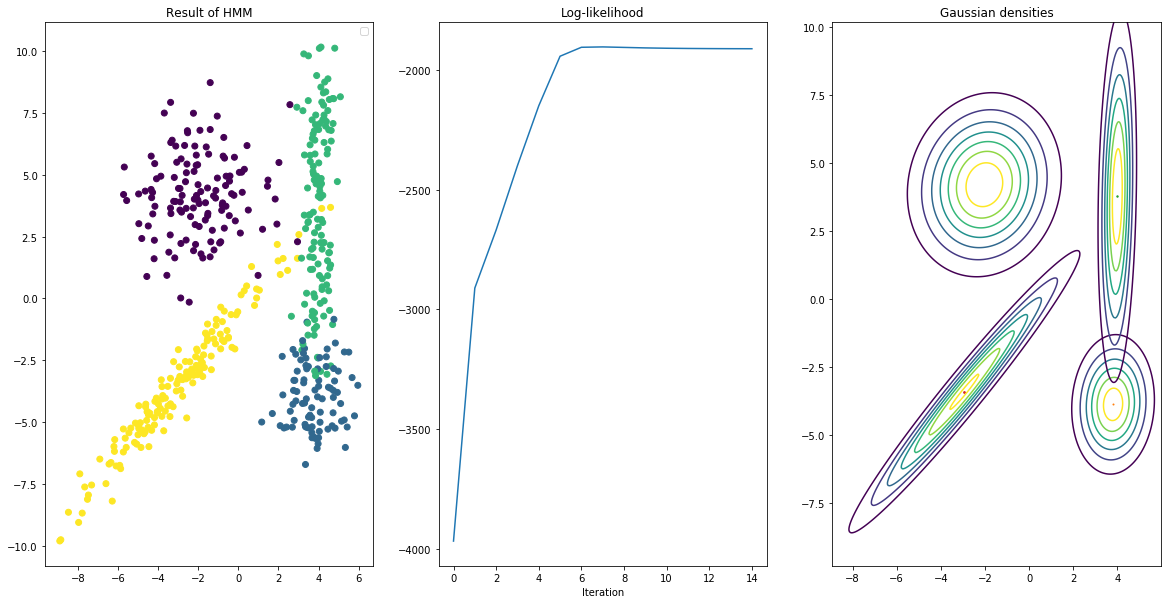

In [150]:
f, (ax2, ax3, ax4) = plt.subplots(1, 3)

n_classes=4
colors = np.array(range(n_classes))

hmm = HMM()

pi1, A, means, sigmas, log_likelihoods = hmm.fit(U, n_classes, 15)

labels=hmm.viterbi(U)

ax2.scatter(U[:,0], U[:,1], c=labels)
x, y, grid = make_grid(U)
ax2.legend()
ax2.set_title('Result of HMM')

ax3.plot(log_likelihoods)
ax3.set_title('Log-likelihood')
ax3.set_xlabel('Iteration')

for col, mu, sigma in zip(colors, means, sigmas):
    ax4.scatter(mu[0], mu[1], col)
    ax4.contour(x, y, gauss(grid, mu, sigma).reshape(x.shape))
ax4.set_title('Gaussian densities')



plt.show()

In [20]:
n_classes = 4

hmm = HMM()
pi1, A, means, sigmas, log_likelihoods = hmm.fit(U, n_classes, Niter=20)


In [ ]:
log_alphas[..., np.newaxis] + log_betas[1:,: , np.newaxis].T
log_alphas[:(T-1), :, np.newaxis].swapaxes(1,2).shape

No handles with labels found to put in legend.


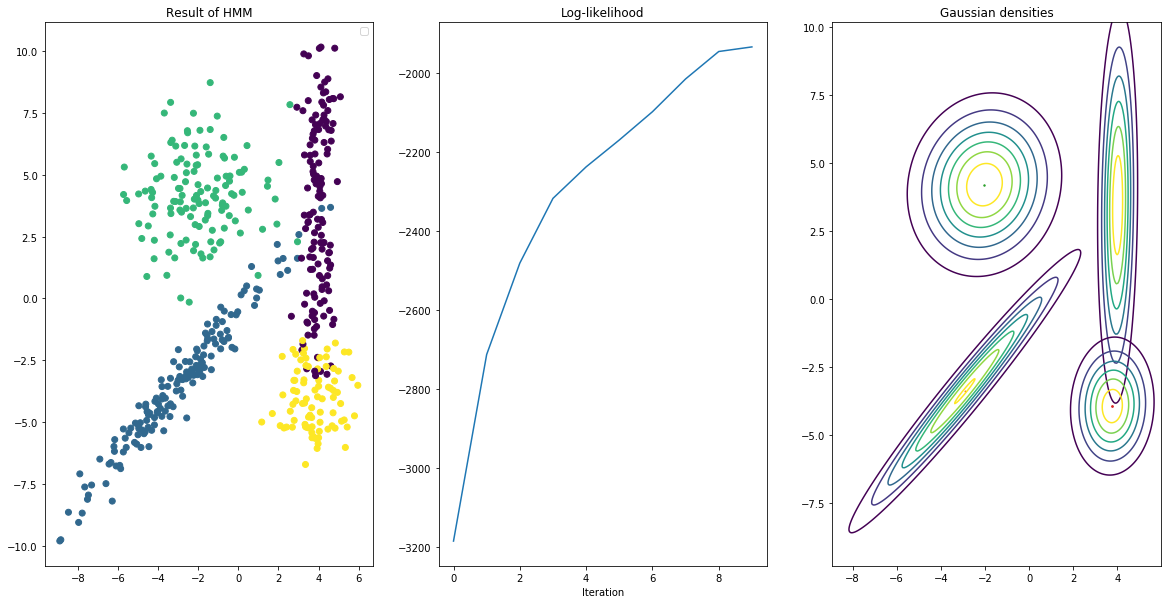

In [83]:
hmm.predict(U)

ValueError: not enough values to unpack (expected 2, got 0)